In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from hyperopt import hp, tpe, fmin, Trials
from tqdm import tqdm
# from tqdm.notebook import tqdm

from collections import OrderedDict, defaultdict
import itertools
from functools import partial
import datetime
from joblib import Parallel, delayed
import copy
import json

from data.dataloader import get_jhu_data, get_covid19india_api_data, get_rootnet_api_data
from data.processing import get_data, get_district_time_series

from models.seir.seir_testing import SEIR_Testing
from main.seir.optimiser import Optimiser
from main.seir.losses import Loss_Calculator
from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import create_region_csv, create_all_csvs, write_csv, plot_forecast

## Comparison of E/Hosp and I/Hosp ratios

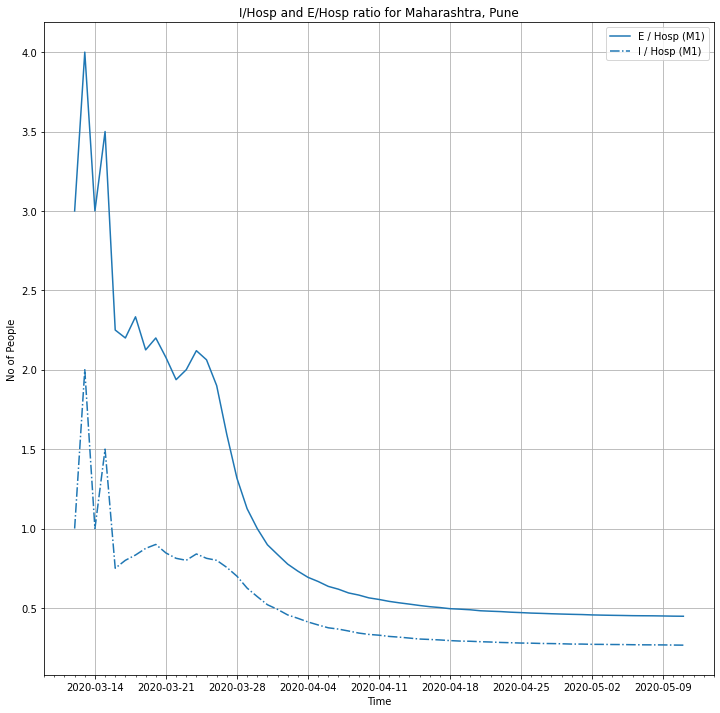

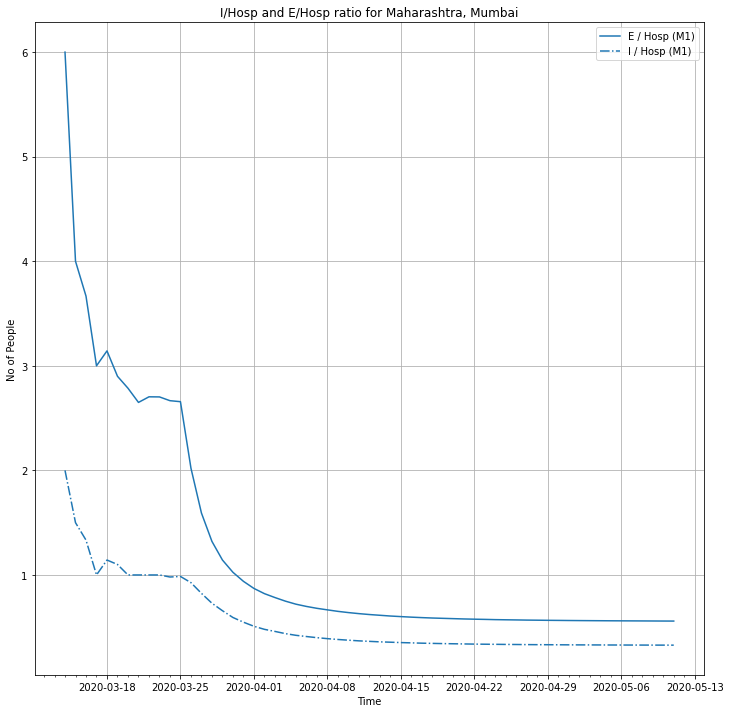

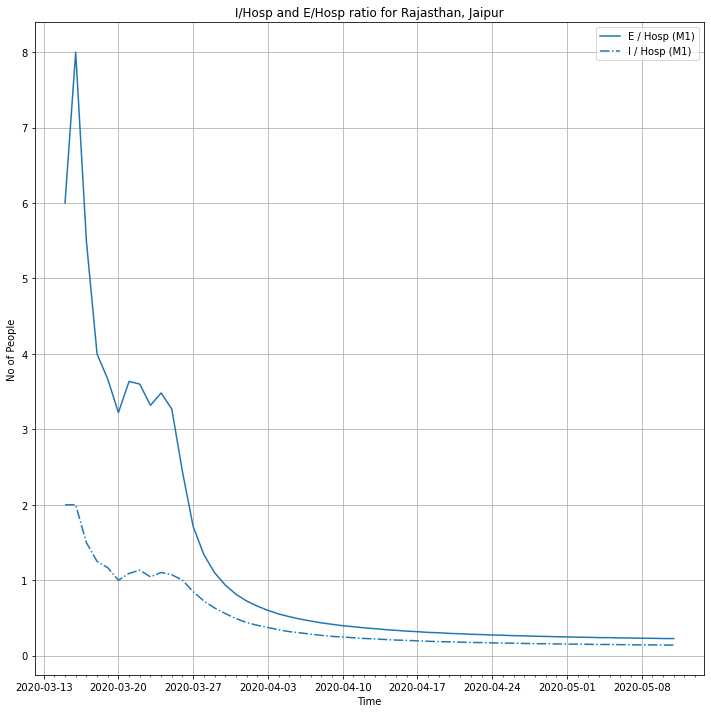

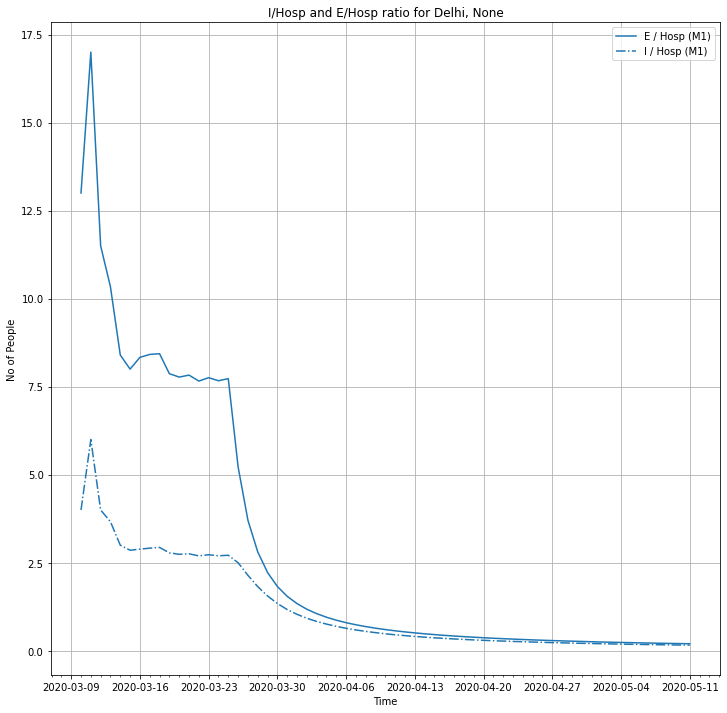

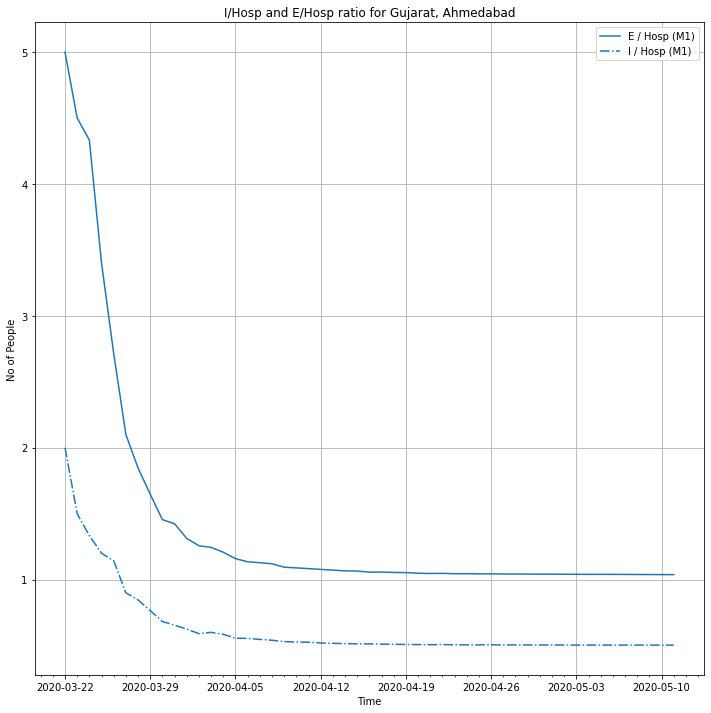

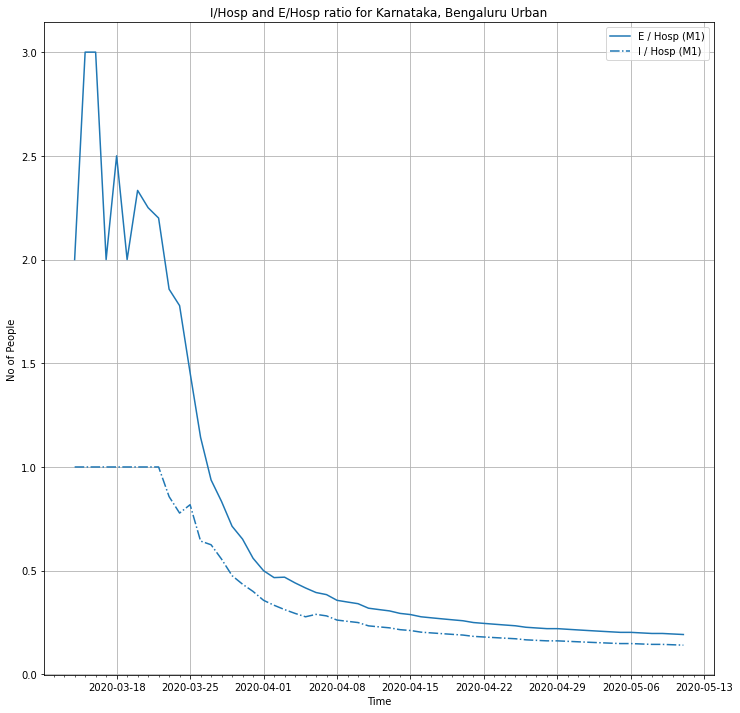

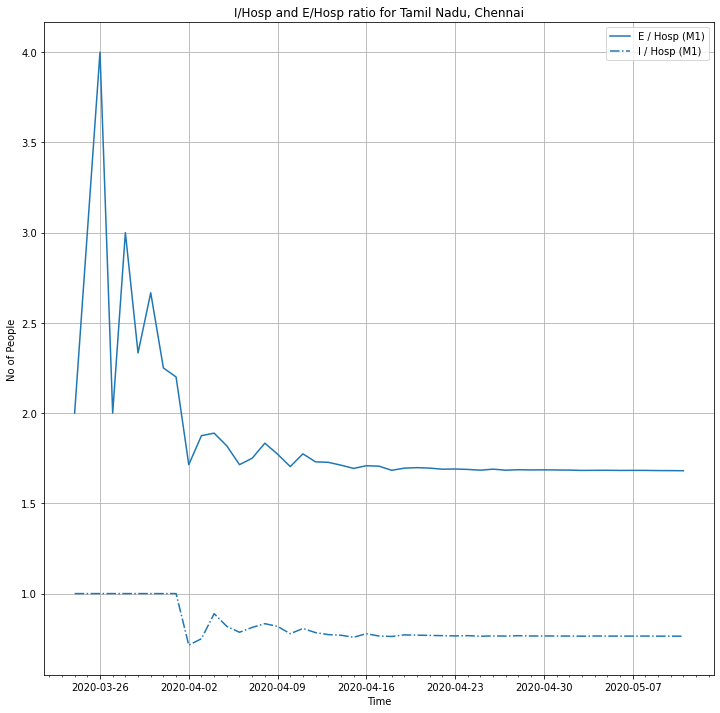

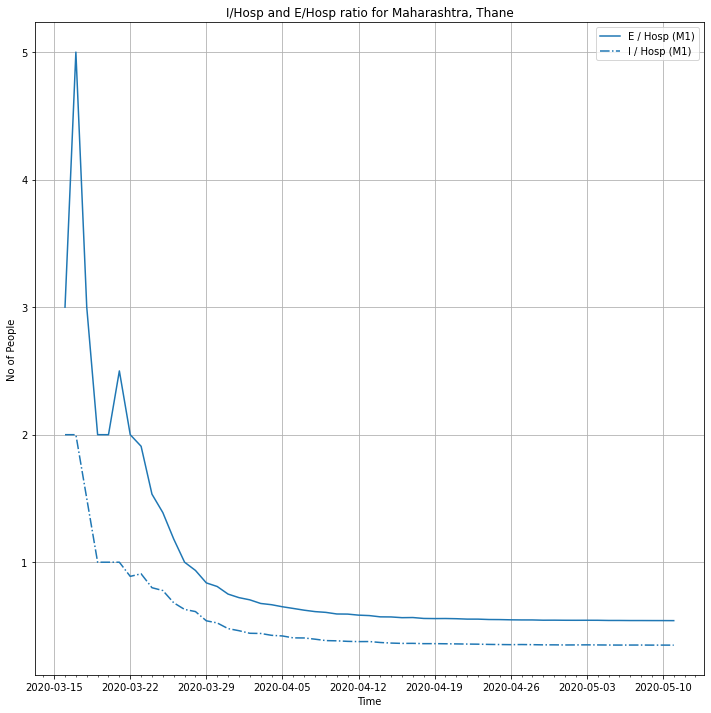

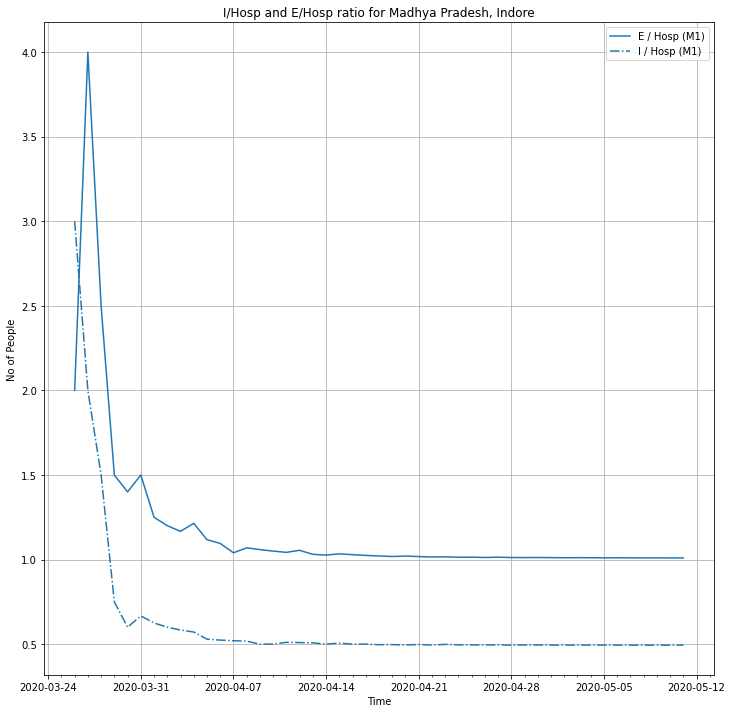

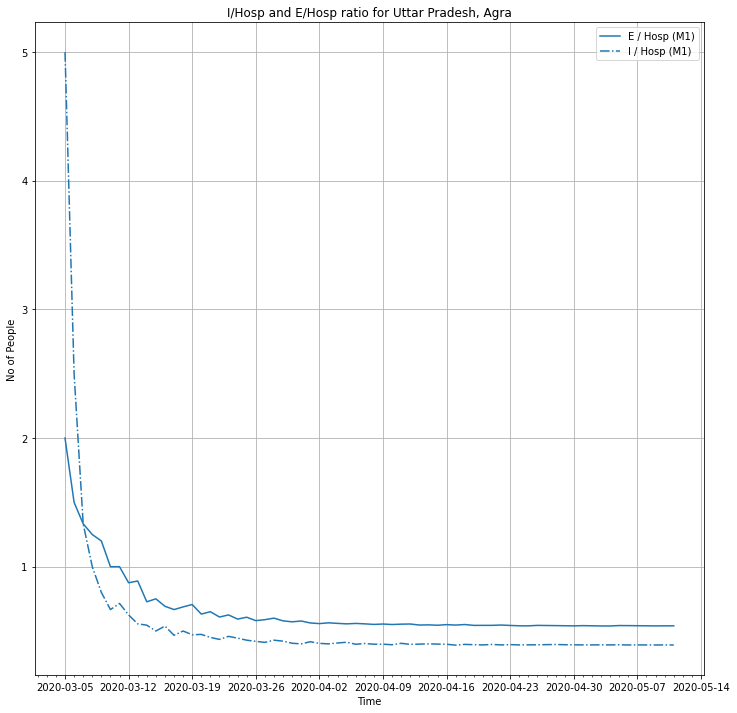

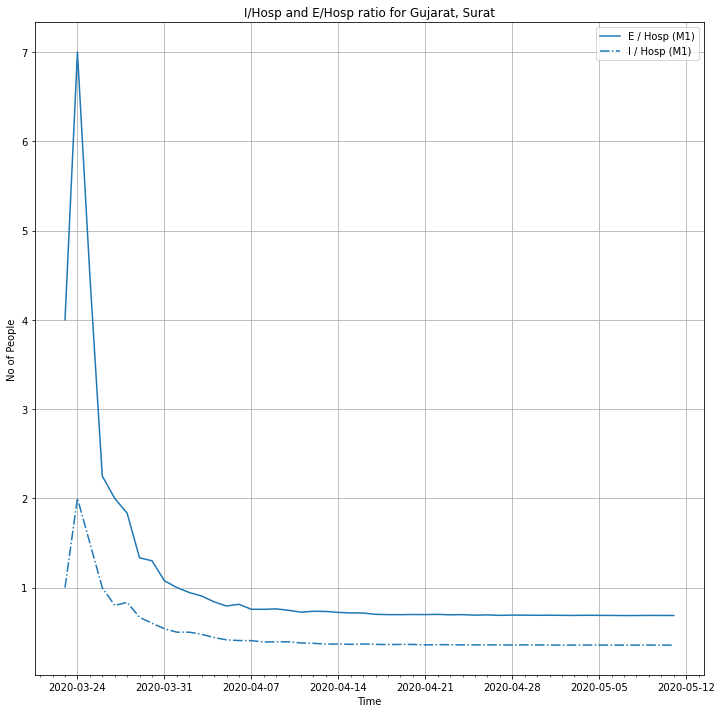

In [171]:
for district in predictions_dict.keys():
    district_dict = predictions_dict[district]
    
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.plot(district_dict['m1']['df_prediction']['date'], district_dict['m1']['df_prediction']['E'] / district_dict['m1']['df_prediction']['hospitalised'],
            '-', color='C0', label='E / Hosp (M1)')
    ax.plot(district_dict['m1']['df_prediction']['date'], district_dict['m1']['df_prediction']['I'] / district_dict['m1']['df_prediction']['hospitalised'],
            '-.', color='C0', label='I / Hosp (M1)')
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.ylabel('No of People')
    plt.xlabel('Time')
    plt.legend()
    plt.title('I/Hosp and E/Hosp ratio for {}, {}'.format(district[0], district[1]))
    plt.grid()
    plt.show()

## Load Covid19india Data

In [3]:
dataframes = get_covid19india_api_data()

In [4]:
predictions_dict = {}

## Select Districts to fit on

In [5]:
# districts_to_show = [('Maharashtra', 'Pune'), 
#                      ('Maharashtra', 'Mumbai'), 
#                      ('Rajasthan', 'Jaipur'), 
#                      ('Gujarat', 'Ahmedabad'), 
#                      ('Karnataka', 'Bengaluru Urban'),
#                      ('Delhi', None)]

districts_to_show = [('Maharashtra', 'Mumbai')]

## Perform M1 and M2 fits

In [6]:
for state, district in districts_to_show:
    predictions_dict[(state, district)] = {}
    predictions_dict[(state, district)]['m1'] = single_fitting_cycle(dataframes, state, district, train_period=7, val_period=7, 
                                                                     data_from_tracker=True, initialisation='intermediate',
                                                                     which_compartments=['hospitalised', 'total_infected'])
    predictions_dict[(state, district)]['m2'] = single_fitting_cycle(dataframes, state, district, train_period=7, val_period=0, 
                                                                     train_on_val=True, data_from_tracker=True, initialisation='intermediate',
                                                                     which_compartments=['hospitalised', 'total_infected'])

fitting to data with "train_on_val" set to False ..


/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


splitting data ..
splitting data ..
train
           state district       date  hospitalised  total_infected  deceased  \
7   Maharashtra   Mumbai 2020-05-03        7038.6          8593.0     338.2   
8   Maharashtra   Mumbai 2020-05-04        7643.4          9323.6     361.4   
9   Maharashtra   Mumbai 2020-05-05        8115.6          9930.6     384.2   
10  Maharashtra   Mumbai 2020-05-06        8647.6         10599.0     408.0   
11  Maharashtra   Mumbai 2020-05-07        9303.8         11411.8     437.2   

    recovered  
7      1216.2  
8      1318.8  
9      1430.8  
10     1543.4  
11     1670.8  
val
          state district       date hospitalised total_infected deceased  \
0  Maharashtra   Mumbai 2020-05-08         9944        12170.6    461.4   
1  Maharashtra   Mumbai 2020-05-09        10530          12932    484.6   
2  Maharashtra   Mumbai 2020-05-10      11052.8        13642.6    508.6   
3  Maharashtra   Mumbai 2020-05-11        11611        14363.6    527.4   
4  Mah

KeyboardInterrupt: 

fitting to data with "train_on_val" set to False ..
splitting data ..
splitting data ..
train
          date  total_infected  deceased  recovered  hospitalised
19 2020-05-02          8081.4     322.2     1618.8        6140.4
20 2020-05-03          8658.2     341.6     1771.6        6545.0
21 2020-05-04          9238.6     365.0     1937.2        6936.4
22 2020-05-05          9848.0     388.0     2112.4        7347.6
23 2020-05-06         10518.8     411.8     2269.4        7837.6
val
         date  total_infected  deceased  recovered  hospitalised
0 2020-05-07         11232.0     437.4     2446.2        8348.4
1 2020-05-08         11993.2     461.6     2621.4        8910.2
2 2020-05-09         12758.8     484.8     2786.0        9488.0
3 2020-05-10         13471.2     508.6     2961.6       10001.0
4 2020-05-11         14194.0     535.4     3202.0       10456.6
5 2020-05-12         14781.0     556.0     3313.0       10912.0
6 2020-05-13         15581.0     596.0     3791.0       11194.

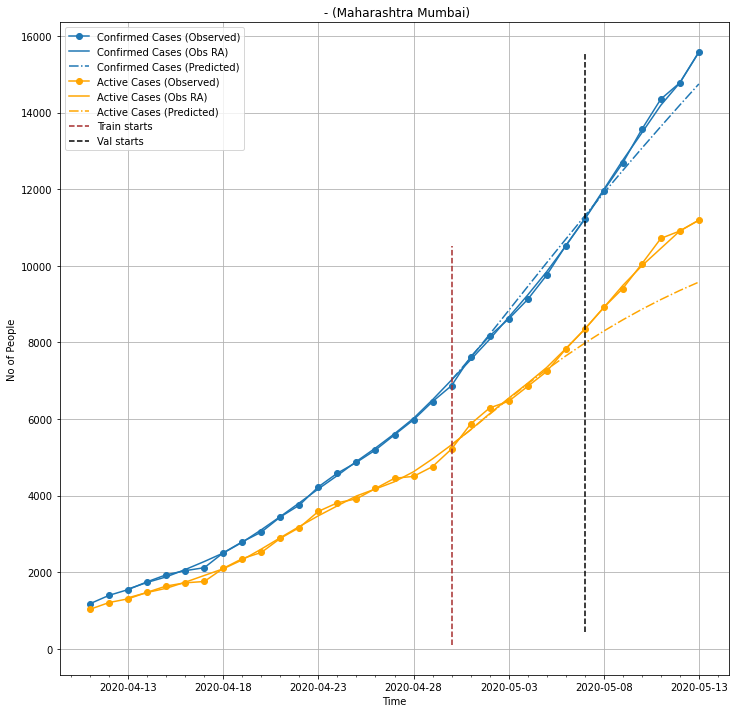

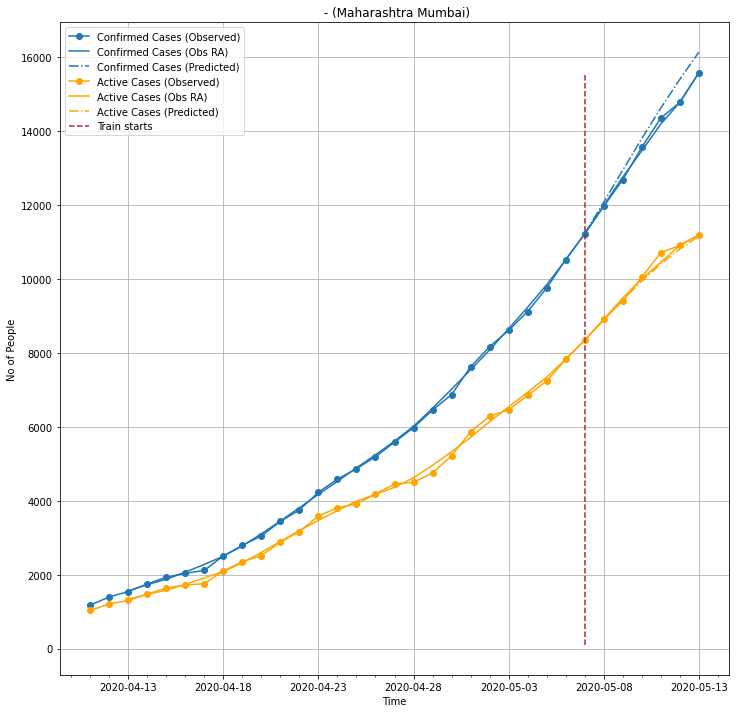

In [7]:
for state, district in districts_to_show:
    predictions_dict[(state, district)] = {}
    predictions_dict[(state, district)]['m1'] = single_fitting_cycle(dataframes, state, district, train_period=7, val_period=7, 
                                                                     data_from_tracker=False, filename='../../data/data/official-mumbai.csv', initialisation='intermediate',
                                                                     which_compartments=['hospitalised', 'total_infected'])
    predictions_dict[(state, district)]['m2'] = single_fitting_cycle(dataframes, state, district, train_period=7, val_period=0, 
                                                                     train_on_val=True, data_from_tracker=False, filename='../../data/data/official-mumbai.csv', initialisation='intermediate',
                                                                     which_compartments=['hospitalised', 'total_infected'])

## Create Master Loss Dataframe

### M1 Loss

In [8]:
starting_key = list(predictions_dict.keys())[0]

loss_columns = pd.MultiIndex.from_product([predictions_dict[starting_key]['m1']['df_loss'].columns, predictions_dict[starting_key]['m1']['df_loss'].index])
loss_index = predictions_dict.keys()

df_loss_master = pd.DataFrame(columns=loss_columns, index=loss_index)
for key in predictions_dict.keys():
    df_loss_master.loc[key, :] = np.around(predictions_dict[key]['m1']['df_loss'].values.T.flatten().astype('float'), decimals=2)
    
df_loss_master

train                         val               
                   hospitalised total_infected hospitalised total_infected
Maharashtra Mumbai         1.76           1.96        12.27           3.09

### M2 Loss

In [9]:
starting_key = list(predictions_dict.keys())[0]

loss_columns = pd.MultiIndex.from_product([predictions_dict[starting_key]['m2']['df_loss'].columns, predictions_dict[starting_key]['m2']['df_loss'].index])
loss_index = predictions_dict.keys()

df_loss_master = pd.DataFrame(columns=loss_columns, index=loss_index)
for key in predictions_dict.keys():
    df_loss_master.loc[key, :] = np.around(predictions_dict[key]['m2']['df_loss'].values.T.flatten().astype('float'), decimals=2)
    
df_loss_master

train               
                   hospitalised total_infected
Maharashtra Mumbai         0.82           2.02

## Plot Forecasts

getting forecasts ..


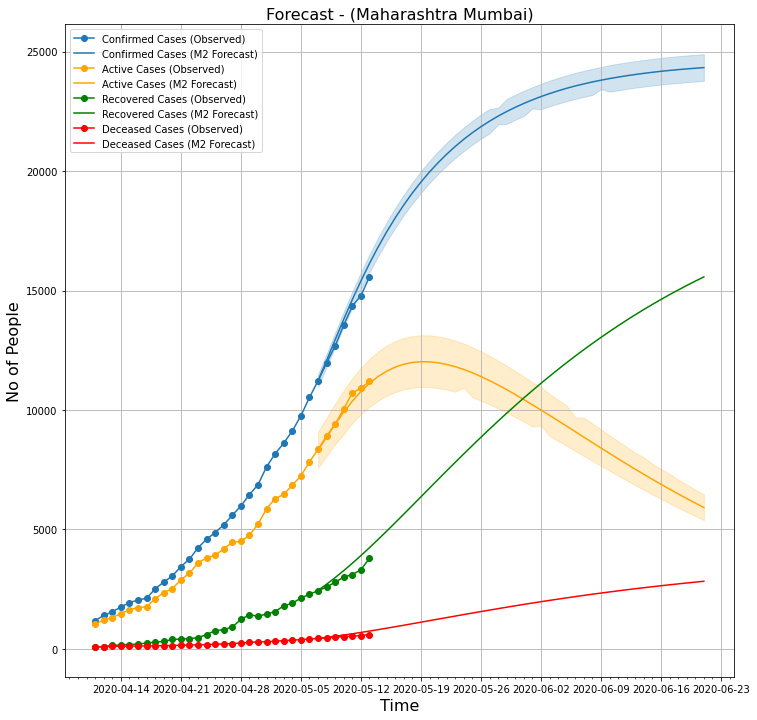

In [17]:
for region in predictions_dict.keys():
    plot_forecast(predictions_dict[region], region, both_forecasts=False, error_bars=True)

## Create and Save Output CSV

In [85]:
df_output = create_all_csvs(predictions_dict, initialisation='intermediate', train_period=7, icu_fraction=0.02)

compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..


In [88]:
write_csv(df_output, '../../output-{}.csv'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

In [60]:
losses_array = np.array([trial['result']['loss'] for trial in predictions_dict[(state, district)]['m1']['trials']])
least_losses_indices = np.argsort(losses_array)
np.sort(losses_array)

array([1.19145808e+01, 1.19183303e+01, 1.22864026e+01, ...,
       1.00000000e+10, 1.00000000e+10, 1.00000000e+10])

In [66]:
params_array = []
for trial in predictions_dict[(state, district)]['m1']['trials']:
    params_dict = copy.copy(trial['misc']['vals'])
    for key in params_dict.keys():
        params_dict[key] = params_dict[key][0]
    params_array.append(params_dict)

params_array = np.array(params_array)

In [64]:
least_losses_indices[:10]

array([1408,  543, 1312,  619, 1446,  464,  787, 1221,  999,  976])

In [65]:
np.sort(losses_array)[:10]

array([11.91458078, 11.91833035, 12.28640263, 12.37358731, 12.38925211,
       12.41115824, 12.53148348, 12.59885204, 12.66810872, 12.7711084 ])

In [72]:
predictions_array = [get_forecast(predictions_dict[('Maharashtra', 'Mumbai')], best_params=params_dict) for params_dict in params_array[least_losses_indices[:10]]]

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..


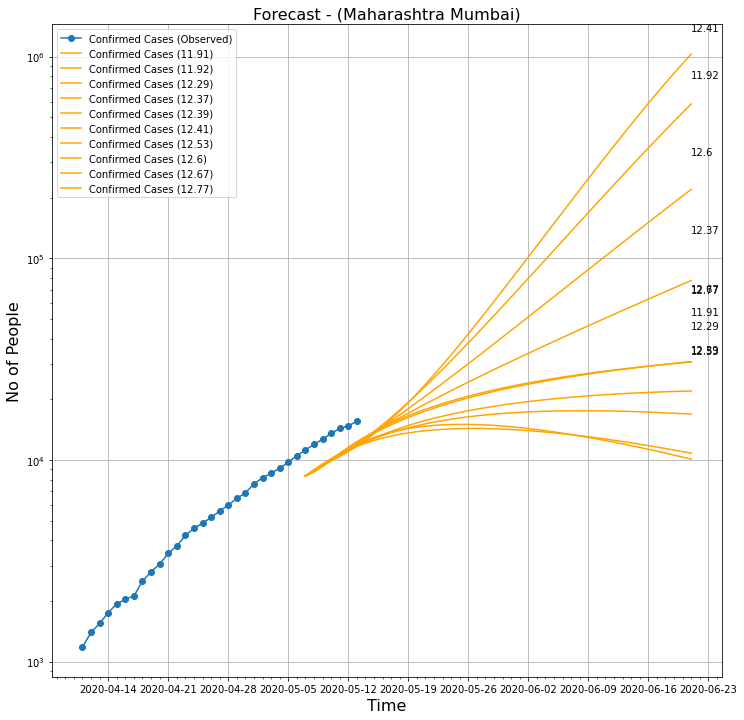

In [103]:
df_true = predictions_dict[('Maharashtra', 'Mumbai')]['m1']['df_district']

fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(df_true['date'], df_true['total_infected'],
        '-o', color='C0', label='Confirmed Cases (Observed)')
for i, df_prediction in enumerate(predictions_array):
    loss_value = np.around(np.sort(losses_array)[:10][i], 2)
    sns.lineplot(x="date", y="total_infected", data=df_prediction,
                 ls='-', color='C0', label='Confirmed Cases ({})'.format(loss_value))
    plt.text(x=df_prediction['date'].iloc[-1], y=df_prediction['total_infected'].iloc[-1], s=loss_value)
    
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('No of People', fontsize=16)
plt.yscale('log')
plt.xlabel('Time', fontsize=16)
plt.legend()
plt.title('Forecast - ({} {})'.format(region[0], region[1]), fontsize=16)
plt.grid()
plt.show()     

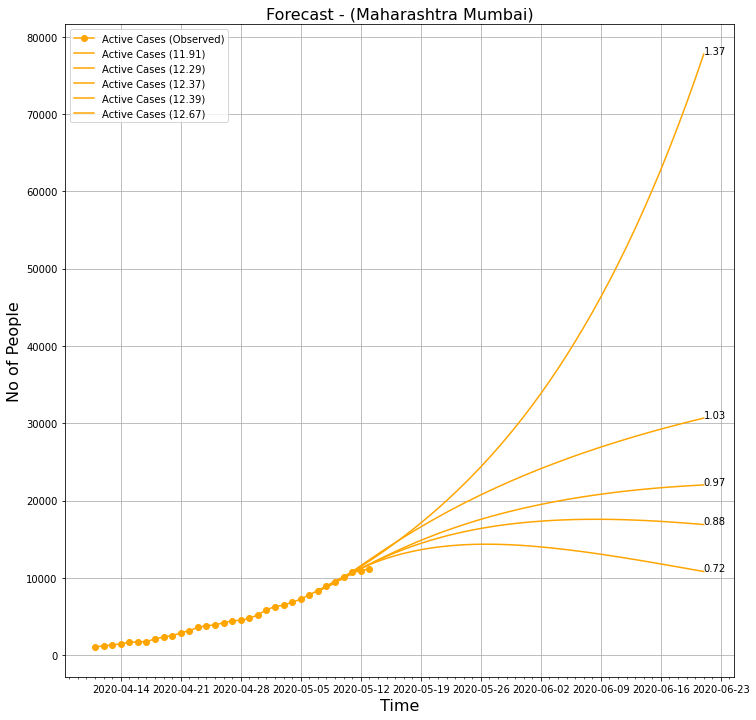

In [105]:
df_true = predictions_dict[('Maharashtra', 'Mumbai')]['m1']['df_district']

fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(df_true['date'], df_true['hospitalised'],
        '-o', color='orange', label='Active Cases (Observed)')
for i, df_prediction in enumerate(predictions_array):
    loss_value = np.around(np.sort(losses_array)[:10][i], 2)
    params_dict = params_array[least_losses_indices[:10]]
    true_r0 = np.around(params_dict[i]['R0']*params_dict[i]['intervention_amount'], 2)
    if true_r0 > 1.7:
        continue
    if true_r0 == 0.59 or true_r0 == 1.04:
        continue
    sns.lineplot(x="date", y="hospitalised", data=df_prediction,
                 ls='-', color='orange', label='Active Cases ({})'.format(loss_value))
    plt.text(x=df_prediction['date'].iloc[-1], y=df_prediction['hospitalised'].iloc[-1], s=true_r0)
    
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('No of People', fontsize=16)
# plt.yscale('log')
plt.xlabel('Time', fontsize=16)
plt.legend()
plt.title('Forecast - ({} {})'.format(region[0], region[1]), fontsize=16)
plt.grid()
plt.show()     

In [90]:
columns = ['forecastRunDate', 'regionType', 'region', 'model_name', 'error_function', 'error_value', 'current_total', 'current_active', 'current_recovered',
           'current_deceased', 'current_hospitalized', 'current_icu', 'current_ventilator', 'predictionDate', 'active_mean', 'active_min',
           'active_max', 'hospitalized_mean', 'hospitalized_min', 'hospitalized_max', 'icu_mean', 'icu_min', 'icu_max', 'deceased_mean',
           'deceased_min', 'deceased_max', 'recovered_mean', 'recovered_min', 'recovered_max', 'total_mean', 'total_min', 'total_max']

region = ('Maharashtra', 'Mumbai')

df_final = pd.DataFrame(columns=columns)
for params_dict in params_array[least_losses_indices[:10]]:
    df_output = create_region_csv(predictions_dict[region], region=region[1], regionType='district', best_params=params_dict,
                                  initialisation='intermediate', train_period=7, icu_fraction=0.02)
    df_final = pd.concat([df_final, df_output], ignore_index=True)
    

compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..


In [92]:
df_final.to_csv('../../outputs/mumbai-{}.csv'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

In [99]:
for index, params_dict in enumerate(params_array[least_losses_indices[:10]]):
    print('Loss - ', np.around(losses_array[least_losses_indices[:10][index]], 2))
    params_dict_temp = copy.copy(params_dict)
    params_dict_temp['true_R0'] = params_dict_temp['R0']*params_dict_temp['intervention_amount']
    del params_dict_temp['intervention_amount']
    del params_dict_temp['R0']
    for key in params_dict_temp.keys():
        params_dict_temp[key] = np.around(params_dict_temp[key], 2)
    print('Params - ', params_dict_temp)
    print('\n')

Loss -  11.91
Params -  {'E_hosp_ratio': 0.69, 'I_hosp_ratio': 0.26, 'P_fatal': 0.11, 'P_severe': 0.89, 'T_inc': 4.63, 'T_inf': 3.07, 'T_recov_severe': 15.94, 'true_R0': 0.97}


Loss -  11.92
Params -  {'E_hosp_ratio': 0.32, 'I_hosp_ratio': 0.33, 'P_fatal': 0.11, 'P_severe': 0.88, 'T_inc': 4.55, 'T_inf': 3.06, 'T_recov_severe': 16.52, 'true_R0': 2.03}


Loss -  12.29
Params -  {'E_hosp_ratio': 0.65, 'I_hosp_ratio': 0.3, 'P_fatal': 0.1, 'P_severe': 0.89, 'T_inc': 4.46, 'T_inf': 3.19, 'T_recov_severe': 15.77, 'true_R0': 0.88}


Loss -  12.37
Params -  {'E_hosp_ratio': 0.64, 'I_hosp_ratio': 0.3, 'P_fatal': 0.11, 'P_severe': 0.88, 'T_inc': 4.72, 'T_inf': 3.15, 'T_recov_severe': 17.17, 'true_R0': 1.37}


Loss -  12.39
Params -  {'E_hosp_ratio': 0.59, 'I_hosp_ratio': 0.34, 'P_fatal': 0.1, 'P_severe': 0.89, 'T_inc': 4.53, 'T_inf': 3.13, 'T_recov_severe': 16.56, 'true_R0': 0.72}


Loss -  12.41
Params -  {'E_hosp_ratio': 0.11, 'I_hosp_ratio': 0.36, 'P_fatal': 0.11, 'P_severe': 0.88, 'T_inc': 4